The aim of this notebook is to code the following approach:

First, solve the colgen without any coverage constraint whatsoever (achieved best by PT NyVA >= with occasional stem-and-blender integer guaranteeing). Then, optimize the coverage vehicle routes according to that job vehicle routing answer.

I'm using this as a starting point into two-stage optimization. I want to make sure I am comfortable manipulating the coverage variables etc. and getting familiar with them.

In [285]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets, Dates

# [0] Drag job data back into this notebook

In [286]:
n_jobs = 25
n_vehicles_jobs = n_jobs
V_cov = 15
T = 2 * n_jobs
min_duration = 2
max_duration = 6;
speed = 1000 / 6;

<b>NOTE:</b> time goes from 0 to T+1 inclusive, but 0 and T+1 are reserved for depot use only. 1 to T is the full working range, inclusive.

In [287]:
time_windows = [[5, 8], [13, 17], [20, 25], [8, 10], [14, 17], [22, 26], [30, 35], 
    [2, 8], [11, 14], [18, 22], [9, 13], [14, 17], [21, 24], [27, 29], [31, 37], 
    [2, 5], [8, 10], [12, 17], [17, 21], [10, 14], [15, 20], [24, 27], [27, 33], 
    [4, 9], [9, 15]];

In [288]:
work_load = [3, 4, 5, 2, 2, 3, 4, 3, 2, 4, 4, 3, 3, 2, 5, 3, 2, 3, 3, 3, 4, 2, 3, 4, 5];

In [289]:
locations = [ [162.98836443179744 274.5255681577834], [109.29332740941533 447.12271410049414],
    [121.1152053108041 446.89270877611096],[89.59124765472993 435.09777866446035],
    [323.92765788592794 498.332645718842],[326.53347225637947 483.83207561135157],
    [328.32265251259605 492.9102875883275],[309.1686841347623 498.8397830821424],
    [36.35807104610789 350.5579177570377],[47.090405717384044 341.3203068534036],
    [55.48085983316444 364.68758998092676],[260.3707024335765 470.9155090761928],
    [260.37715114996485 479.54934664105195],[247.26012681195274 464.00956357114217], 
    [240.48176081945687 456.302922303405],[276.6482779863586 455.5862703353655],
    [239.93121460946887 474.9841599335543],[251.64446751105916 493.673348915355], 
    [246.70672450784087 490.66852195024524],[232.51197192211055 487.17296281307057], 
    [244.46684180873675 245.79037260667468],[225.94275471532777 256.0041140341042],
    [231.9341041485549 256.19089982535576],[241.8876807998831 230.46206318844872],
    [73.90222246114125 139.66111885815096],[65.10392466179182 147.0898582966076]];

In [290]:
distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];

In [291]:
travel_times = ceil.(distances / speed);

In [292]:
routes_nodes_only = [
    [0, 1, 2, 3, 26],
    [0, 8, 9, 10, 26],
    [0, 4, 5, 6, 7, 26],
    [0, 20, 21, 22, 23, 26],
    [0, 24, 25, 26],
    [0, 11, 12, 15, 26],
    [0, 16, 17, 18, 19, 13, 14, 26]
];

In [293]:
full_routes = [
[[[0, 0], [1, 5], 180.7565539293233], [[1, 5], [1, 6], 0], [[1, 6], [1, 7], 0], [[1, 7], [1, 8], 0], [[1, 8], [2, 13], 11.824115170472117], [[2, 13], [2, 14], 0], [[2, 14], [2, 15], 0], [[2, 15], [2, 16], 0], [[2, 16], [2, 17], 0], [[2, 17], [3, 20], 33.658286983158845], [[3, 20], [3, 21], 0], [[3, 21], [3, 22], 0], [[3, 22], [3, 23], 0], [[3, 23], [3, 24], 0], [[3, 24], [3, 25], 0], [[3, 25], [26, 27], 176.55189474538938]],
[[[0, 0], [8, 2], 147.70290920807565], [[8, 2], [8, 3], 0], [[8, 3], [8, 4], 0], [[8, 4], [8, 5], 0], [[8, 5], [9, 11], 14.160383564833829], [[9, 11], [9, 12], 0], [[9, 12], [9, 13], 0], [[9, 13], [10, 18], 24.828001148518656], [[10, 18], [10, 19], 0], [[10, 19], [10, 20], 0], [[10, 20], [10, 21], 0], [[10, 21], [10, 22], 0], [[10, 22], [26, 23], 140.31056169890445]],
[[[0, 0], [4, 8], 275.66476768701585], [[4, 8], [4, 9], 0], [[4, 9], [4, 10], 0], [[4, 10], [5, 14], 14.732847721180612], [[5, 14], [5, 15], 0], [[5, 15], [5, 16], 0], [[5, 16], [6, 22], 9.252842735513466], [[6, 22], [6, 23], 0], [[6, 23], [6, 24], 0], [[6, 24], [6, 25], 0], [[6, 25], [7, 30], 20.050771093158136], [[7, 30], [7, 31], 0], [[7, 31], [7, 32], 0], [[7, 32], [7, 33], 0], [[7, 33], [7, 34], 0], [[7, 34], [26, 36], 267.74157855214145]],
[[[0, 0], [20, 10], 86.39707019931214], [[20, 10], [20, 11], 0], [[20, 11], [20, 12], 0], [[20, 12], [20, 13], 0], [[20, 13], [21, 15], 21.153305098508625], [[21, 15], [21, 16], 0], [[21, 16], [21, 17], 0], [[21, 17], [21, 18], 0], [[21, 18], [21, 19], 0], [[21, 19], [22, 24], 5.99426033492411], [[22, 24], [22, 25], 0], [[22, 25], [22, 26], 0], [[22, 26], [23, 27], 27.587075286128385], [[23, 27], [23, 28], 0], [[23, 28], [23, 29], 0], [[23, 29], [23, 30], 0], [[23, 30], [26, 31], 90.36976592607648]],
[[[0, 0], [24, 4], 161.63155748834768], [[24, 4], [24, 5], 0], [[24, 5], [24, 6], 0], [[24, 6], [24, 7], 0], [[24, 7], [24, 8], 0], [[24, 8], [25, 9], 11.515042935678439], [[25, 9], [25, 10], 0], [[25, 10], [25, 11], 0], [[25, 11], [25, 12], 0], [[25, 12], [25, 13], 0], [[25, 13], [25, 14], 0], [[25, 14], [26, 15], 160.68983694344095]],
[[[0, 0], [11, 9], 219.20841372682088], [[11, 9], [11, 10], 0], [[11, 10], [11, 11], 0], [[11, 11], [11, 12], 0], [[11, 12], [11, 13], 0], [[11, 13], [12, 14], 8.63383997317047], [[12, 14], [12, 15], 0], [[12, 15], [12, 16], 0], [[12, 16], [12, 17], 0], [[12, 17], [15, 31], 28.96512721460351], [[15, 31], [15, 32], 0], [[15, 32], [15, 33], 0], [[15, 33], [15, 34], 0], [[15, 34], [15, 35], 0], [[15, 35], [15, 36], 0], [[15, 36], [26, 38], 213.77921747042998]],
[[[0, 0], [16, 2], 214.71806912830775], [[16, 2], [16, 3], 0], [[16, 3], [16, 4], 0], [[16, 4], [16, 5], 0], [[16, 5], [17, 8], 22.056429410357314], [[17, 8], [17, 9], 0], [[17, 9], [17, 10], 0], [[17, 10], [18, 12], 5.780163583851407], [[18, 12], [18, 13], 0], [[18, 13], [18, 14], 0], [[18, 14], [18, 15], 0], [[18, 15], [19, 17], 14.618821246994681], [[19, 17], [19, 18], 0], [[19, 18], [19, 19], 0], [[19, 19], [19, 20], 0], [[19, 20], [13.0, 21.0], 27.45999157129779], [[13.0, 21.0], [13.0, 22.0], 0], [[13.0, 22.0], [13.0, 23.0], 0], [[13.0, 23.0], [13.0, 24.0], 0], [[13.0, 24.0], [14.0, 27.0], 10.263457758368471], [[14.0, 27.0], [14.0, 28.0], 0], [[14.0, 28.0], [14.0, 29.0], 0], [[14.0, 29.0], [26.0, 31.0], 197.60625740061383]],
];

# [1] Create Coverage Locations

## [1.1] Parameters

The following parameters detail how the grid will shape up. Size is the side length of the full map square, mesh is the width of the 'meshing' of the grid (e.g. mesh = 40 means every 40 distance in horizontal or vertical direction there will be a new vehicle), which will be a square system. Radius is how well the coverage does, as the crow flies (so not Manhattan/taxicab). Speed is how far we travel per time unit.

In [294]:
size = 500
mesh = 50
radius = 50
speed = 1000/6;

## [1.2] Consider each potential landing spot for coverage, and see if useful

So now we have a full grid set up, with locations ranging from

`[0, size]` to `[0, size]` with a mesh, or mesh, of `mesh`. Start with `[0, 0]`; we expect mesh to be divided into size evenly, but if not, like if size is 100 and mesh is 8, we end at `[96, 96]`.

We consider each of these `floor(size / mesh) + 1` times `floor(size / mesh) + 1` locations, and see if, within their coverage, there exists at least a job. How do we run this check? It's kinda hard to 'sweep' the coverage and look for jobs, so instead, we take jobs and match their distance against the radius-squared!

If there is at least a job within the radius, then the coverage location is useful.

If not, then don't add it.

In [295]:
function is_close_enough(coverage_loc, job_loc, r)
    #=
    Given a coverage_loc with 2 elements x y
    and a job_loc with two elements x y
    determines if that specific job_loc is located within r 
    of the coverage_loc as the crow flies
    =#
    
    return (coverage_loc[1]-job_loc[1])^2 + (coverage_loc[2]-job_loc[2])^2 <= r^2
end;

In [296]:
coverage_locations = []

for x in 0:mesh:size
    for y in 0:mesh:size
        potential_cov = [x y]
        useful = false
        # println("Now considering ", potential_cov)
        
        for index in 2:length(locations) #1st is depot
            if is_close_enough(potential_cov, locations[index], radius)
                # println(potential_cov, " is close enough to ", locations[index])
                useful = true
                break
            end
        end
        
        if useful
            push!(coverage_locations, potential_cov)
        end
    end
end;

In [297]:
coverage_locations;

In [298]:
m_cov = length(coverage_locations);

## [1.3] Generate map of coverage and job locations

This is good for visual inspection and seeing if we want to change anything.

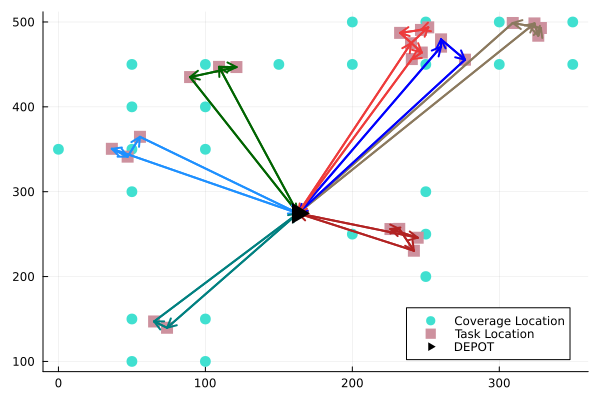

In [299]:
x_values = []
y_values = []
for i in 2:length(locations)
    push!(x_values, locations[i][1])
    push!(y_values, locations[i][2])
end

cov_x = []
cov_y = []
for i in 1:length(coverage_locations)
    push!(cov_x, coverage_locations[i][1])
    push!(cov_y, coverage_locations[i][2])
end

xcs = []
ycs = []
xvecs = []
yvecs = []
# now, the arrows to indicate routes
for route_node_series in routes_nodes_only
    xc, yc, xv, yv = [], [], [], []
    for index in 1:length(route_node_series)-1
        lindex1 = 1 + route_node_series[index] % (n_jobs+1)
        lindex2 = 1 + route_node_series[index+1] % (n_jobs+1)
        x1, y1 = locations[lindex1]
        x2, y2 = locations[lindex2]
        push!(xc, x1); push!(yc, y1); push!(xv, x2-x1); push!(yv, y2-y1)
    end
    push!(xcs, xc); push!(ycs, yc); push!(xvecs, xv); push!(yvecs, yv)
end

scatter(cov_x, cov_y; label = "Coverage Location", markershape = :circle,
markercolor = :turquoise, markersize = 6, markerstrokecolor = :turquoise, markerstrokewidth=3,)
scatter!(x_values, y_values; label = "Task Location", markershape = :square, 
markercolor = :pink3, markersize = 6, markerstrokecolor = :pink3, markerstrokewidth = 3)
colors = [:darkgreen, :dodgerblue, :navajowhite4, :firebrick, :teal, :blue, :brown2]
for i in 1:length(xcs)
    quiver!(xcs[i], ycs[i], quiver = (xvecs[i], yvecs[i]), linewidth=2, c=colors[i])
end
display(scatter!([locations[1][1]], [locations[1][2]]; label = "DEPOT", markershape = :rtriangle,
markercolor = :black, markersize = 15, markerstrokecolor = :black))

# [2] Prepare Calculations for CG Model

## [2.1] Coverage Distances and Travel Times

First we need to gather distances to and from the depot and other coverage locations. To do so most quickly, we temporarily modify coverage locations to also include the depot.

In [300]:
insert!(coverage_locations, 1, locations[1]);

In [301]:
coverage_distances = [LinearAlgebra.norm(coverage_locations[i, :] .- coverage_locations[j, :]) for i=1:m_cov+1, j = 1:m_cov+1];

In [302]:
coverage_locations = coverage_locations[2:end];

In [303]:
travel_times = ceil.(coverage_distances / speed);

## [2.2] $L_{ji}$

Whether coverage spot $j$ is close enough to job node $i$ to cover. 1 if yes, 0 if no.

In [304]:
function calculate_L(cov_locs, job_locs, r=radius)
    #=
    Given a list of tuple coverage locations and job locations,
    returns a matrix of L values. Specifically, 
    L[j][i], indicating if spot j is close enough to node i
    for coverage to happen.
    =#
    L = []
    for j in 1:length(cov_locs)
        L_j = []
        cov_loc = cov_locs[j]
        for i in 1:length(job_locs)
            push!(L_j, (is_close_enough(cov_loc, job_locs[i], r)) ? 1 : 0)
        end
        push!(L, L_j)
    end
    
    return L
end;

In [305]:
L = calculate_L(coverage_locations, locations[2:end], radius);

## [2.3] $W_{it}$

Whether a job is being performed at job node $i$ at time $t$.

In [306]:
function calculate_W(full_routes)
    #=
    Given the full solution routes to the job problem,
    tells us W[i][t], which is whether job i is being
    done at time t.
    
    Our strategy is to gather the FIRST node of each arc,
    because it's the same as the second node of the arc prior.
    
    Disregard the 1st node (its start is the origin-depot), 
    that information is contained in the 2nd node.
    =#
    W = [ [0 for t in 1:T] for i in 1:n_jobs]
    
    for route in full_routes
        for arc in route[2:end]
            loc = Int(arc[1][1])
            time = Int(arc[1][2])
            W[loc][time] = 1
        end
    end
    
    return W
end;   

In [307]:
W = calculate_W(full_routes);

## [2.4] Function for route cost

What is the cost of a route? The sum of its `arc[3]`'s.

In [308]:
function cost_of_route(route)
    ans = 0
    for arc in route
        ans += arc[3]
    end
    return ans
end;

# [3] Generate Routes and Their Parameters

Idea: Send a vehicle to every single coverage spot. Have it stay there until the bitter end.

## [3.1] Generate Routes

In [309]:
V_cov = m_cov;

In [310]:
routes = []
for j in 1:m_cov
    route = []
    travel_time = travel_times[0+1, j+1]
    dist = coverage_distances[0+1, j+1]
    push!(route, [ [0, 0], [j, travel_time], dist ])
    for t in travel_time:T - travel_time
        push!(route, [ [j, t], [j, t+1], 0])
        # so the last one has time T-travel_time to T-travel_time+1
    end
    push!(route, [ [j, T - travel_time+1], [m_cov + 1, T + 1], dist])
    push!(routes, route)
end;

In [311]:
num_routes = length(routes);

## [3.2] Generate Route Costs

In [312]:
C = [cost_of_route(route) for route in routes];

## [3.3] Generate $y_{jt}^p$

If route $p$ is at spot $j$ at time $t$.

In [313]:
function generate_y(routes)
    y = [[[0 for p in 1:length(routes)] for t in 1:T] for j in 1:m_cov]
    
    for rindex in 1:length(routes)
        route = routes[rindex]
        for arc in route
            job1, time1 = Int.(arc[1])
            job2, time2 = Int.(arc[2])
            if job1 != 0
                y[job1][time1][rindex] = 1
            end
            if job2 != m_cov + 1
                y[job2][time2][rindex] = 1
            end
        end
    end
    return y
end;

In [314]:
y = generate_y(routes);

# [4] CG Model

In [315]:
model = Model(Gurobi.Optimizer);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


In [316]:
V_cov = m_cov;

## [4.1] Variables

In [317]:
@variable(model, 0 <= x[1:num_routes] <= 1);

## [4.2] Objective

In [318]:
@objective(model, Min, 
    sum(x[p] * C[p] for p in 1:num_routes));

## [4.3] Constraints

In [319]:
@constraint(model, enough_vehicles, sum(x[p] for p in 1:num_routes) <= V_cov);

In [320]:
@constraint(model, work_covered[i in 1:n_jobs, t in 1:T], 
    sum(sum(L[j][i] * y[j][t][p] * x[p] for j in 1:m_cov) for p in 1:num_routes) >= W[i][t]);

In [321]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1251 rows, 25 columns and 3713 nonzeros
Model fingerprint: 0x60791681
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+01, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 1233 rows and 4 columns
Presolve time: 0.00s
Presolved: 18 rows, 21 columns, 54 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8800105e+01   1.800000e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       9    1.9319330e+03   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.931933027e+03

User-callback calls 68, time in user-callback 0.00 sec


# [5] Parameters and Functions in Preparation for SP

## [5.1] Node Neighborhoods

In [322]:
function neighborhood(j)
    #= returns all nodes i
    which are close to the spot j.
    =#
    
    cov_loc = coverage_locations[j]
    
    close = []
    for i in 1:n_jobs
        if is_close_enough(cov_loc, locations[i+1], radius)
            push!(close, i)
        end
    end
    
    return close
end;

## [5.2] Until Nodes are Exhausted

My first heuristic is to have a coverage vehicle stay until the nodes in the neighborhood are all done. When does this happen?

In [323]:
function last_1_index(list)
    # returns index of last 1 in list.
    last_index = -1
    for i in 1:length(list)
        if list[i] == 1
            last_index = i
        end
    end
    
    return last_index
end;

In [324]:
function until_exhausted(j)
    #=
    returns the time at which all nodes i
    close to spot j have finished working.
    INCLUSIVE, so if the last job 
    works from [32, 36], then I return 36, NOT 37.
    =#
    
    neigh_jobs = neighborhood(j)
    
    last_time = 0
    for job_index in neigh_jobs
        candidate_time = last_1_index(W[job_index])
        if candidate_time > last_time
            last_time = candidate_time
        end
    end
    return last_time
end;        

## [5.3] Gather Dual Variables

In [325]:
beta = dual.(enough_vehicles);

In [326]:
xi = dual.(work_covered);

## [5.4] Get Minimum Reduced Cost Index

In [327]:
function mindex(rcs)
    index = 1
    min_value = rcs[1]
    
    for i in 2:length(rcs)
        value = rcs[i]
        if value < min_value
            index = i
            min_value = value
        end
    end
    return index
end;

## [5.5] Generate Full Route Info

In [328]:
function generate_full_time_info(best_route, best_times)
    #=
    given the route info and time info, returns all arcs appropriate.
    =#
    best_route_info = []
    
    for locindex in 1:length(best_route)-1
        cur_loc, new_loc = best_route[locindex:locindex+1]
        cur_time, new_time = best_times[locindex:locindex+1]
        
        #=
        Take the new_time and subtract the
        amount of time it takes to travel there.
        The remaining time is entirely stationary.
        =#
        
        travel_time = travel_times[cur_loc+1, new_loc % (m_cov+1) + 1]
        dist = coverage_distances[cur_loc+1, new_loc % (m_cov+1) + 1]
        
        for stationary_time in cur_time:new_time-travel_time-1
            route_detail = [[cur_loc, stationary_time], [cur_loc, stationary_time+1], 0]
            push!(best_route_info, route_detail)
        end
        
        route_detail = [[cur_loc, new_time-travel_time], [new_loc, new_time], dist]
        push!(best_route_info, route_detail)
    end

    return best_route_info
end;

# [6] SP LSA

In [329]:
function sp_lsa(n, m, dists, trav_times, beta, xi)
    paths = [ [0] ]
    times = [ [0] ]
    red_costs = [beta]
    cur_pointer = 1
    tot_pointer = 1
    
    for i in 1:1000
        cur_path = paths[cur_pointer]
        last_cur_spot = last(cur_path)
        
        #check if we want to move on
        if (last_cur_spot == m + 1) || (last(times[cur_pointer]) >= T+1)
            cur_pointer += 1
            if cur_pointer > tot_pointer
                break
            else
                continue
            end
        end
        
        # enter the loop for appending.
        for j in 1:m+1
            
            #check that this is a new node
            if ~(j in cur_path)
                
                cur_time = last(times[cur_pointer])
                travel_time = trav_times[last_cur_spot+1, j % (m+1) + 1]
                segment_cost = dists[last_cur_spot+1, j % (m+1) + 1]
                
                cur_rc = red_costs[cur_pointer]
                new_rc = cur_rc
                new_rc += segment_cost
                
                # you have to stay until the nodes exhausted from old.
                xi_reduction = 0
                if last_cur_spot > 0
                    cur_neigh = neighborhood(last_cur_spot)
                    for t in cur_time:until_exhausted(last_cur_spot)
                        for neighbor_index in cur_neigh
                            xi_reduction -= xi[neighbor_index, t]
                        end
                    end
                end
                
                new_rc += xi_reduction
                push!(red_costs, new_rc)
                #this finishes reduced costs, now onto time
                
                #=
                Timewise: You got to the current spot at
                cur_time and are now trying to move to node j.
                You have to stay at the current spot until time
                until_exhausted(last_cur_spot), at which point
                you make your move. This takes the distance
                specified.
                =#
                last_cur_time = cur_time
                if last_cur_spot > 0
                    last_cur_time = max(until_exhausted(last_cur_spot), cur_time)
                end
                new_times = copy(times[cur_pointer])
                push!(new_times, last_cur_time + travel_time)
                push!(times, new_times)
                
                new_path = copy(cur_path)
                push!(new_path, j)
                push!(paths, new_path)
                tot_pointer += 1
            end
        end
        
        cur_pointer += 1
        
        if cur_pointer == tot_pointer
            break
        end
    end
    
    return paths, times, red_costs
end;

In [330]:
paths, times, rcs = sp_lsa(n_jobs, m_cov, coverage_distances, travel_times, beta, xi);

In [331]:
proper_paths, proper_times, proper_rcs = [], [], []
for index in 1:length(paths)
    if last(paths[index]) == m_cov + 1
        push!(proper_paths, paths[index])
        push!(proper_times, times[index])
        push!(proper_rcs, rcs[index])
    end
end;

In [332]:
best_index = mindex(proper_rcs);

In [333]:
new_route = generate_full_time_info(paths[best_index], times[best_index]);

In [334]:
println(proper_rcs[best_index])

0.0
